In [118]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [119]:
# Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# Load the datasets
usd_data = pd.read_csv('/content/drive/MyDrive/dataset/us_dollar.csv', sep=',')
bitcoin_data = pd.read_csv('/content/drive/MyDrive/dataset/bitcoin.csv', sep=',')
nasdaq_data = pd.read_csv('/content/drive/MyDrive/dataset/nasdaq.csv', sep=',')

In [121]:
# Remove commas from 'Price' column and convert to float
nasdaq_data['Price'] = nasdaq_data['Price'].str.replace(',', '').astype(float)

In [122]:
# Define preprocess_data function
def preprocess_data(data, seq_length):
    # Scaling data
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[['Price']])

    X = []
    y = []
    for i in range(len(data_scaled) - seq_length):
        X.append(data_scaled[i:i+seq_length])
        y.append(data_scaled[i+seq_length])

    X = np.array(X)
    y = np.array(y)

    return X, y, scaler

In [123]:
# Split Data Function
def split_data(X, y, train_ratio=0.7, val_ratio=0.2):
    total_samples = len(X)
    train_end = int(total_samples * train_ratio)
    val_end = int(total_samples * (train_ratio + val_ratio))

    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [124]:
# Prepare the data
seq_length = 30

In [125]:
# USD Data
X_usd, y_usd, usd_scaler = preprocess_data(usd_data, seq_length)
X_train_usd, y_train_usd, X_val_usd, y_val_usd, X_test_usd, y_test_usd = split_data(X_usd, y_usd)

In [126]:
# Bitcoin Data
X_bitcoin, y_bitcoin, bitcoin_scaler = preprocess_data(bitcoin_data, seq_length)
X_train_bitcoin, y_train_bitcoin, X_val_bitcoin, y_val_bitcoin, X_test_bitcoin, y_test_bitcoin = split_data(X_bitcoin, y_bitcoin)

In [127]:
# Nasdaq Data
X_nasdaq, y_nasdaq, nasdaq_scaler = preprocess_data(nasdaq_data, seq_length)
X_train_nasdaq, y_train_nasdaq, X_val_nasdaq, y_val_nasdaq, X_test_nasdaq, y_test_nasdaq = split_data(X_nasdaq, y_nasdaq)

In [128]:
# Convert to PyTorch Tensors
def to_tensors(X, y):
    X_tensor = torch.from_numpy(X).float()
    y_tensor = torch.from_numpy(y).float()
    return X_tensor, y_tensor

X_train_usd, y_train_usd = to_tensors(X_train_usd, y_train_usd)
X_val_usd, y_val_usd = to_tensors(X_val_usd, y_val_usd)
X_test_usd, y_test_usd = to_tensors(X_test_usd, y_test_usd)

X_train_bitcoin, y_train_bitcoin = to_tensors(X_train_bitcoin, y_train_bitcoin)
X_val_bitcoin, y_val_bitcoin = to_tensors(X_val_bitcoin, y_val_bitcoin)
X_test_bitcoin, y_test_bitcoin = to_tensors(X_test_bitcoin, y_test_bitcoin)

X_train_nasdaq, y_train_nasdaq = to_tensors(X_train_nasdaq, y_train_nasdaq)
X_val_nasdaq, y_val_nasdaq = to_tensors(X_val_nasdaq, y_val_nasdaq)
X_test_nasdaq, y_test_nasdaq = to_tensors(X_test_nasdaq, y_test_nasdaq)

In [129]:
# Create DataLoader
def create_dataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=32):
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

train_loader_usd, val_loader_usd, test_loader_usd = create_dataloader(X_train_usd, y_train_usd, X_val_usd, y_val_usd, X_test_usd, y_test_usd)
train_loader_bitcoin, val_loader_bitcoin, test_loader_bitcoin = create_dataloader(X_train_bitcoin, y_train_bitcoin, X_val_bitcoin, y_val_bitcoin, X_test_bitcoin, y_test_bitcoin)
train_loader_nasdaq, val_loader_nasdaq, test_loader_nasdaq = create_dataloader(X_train_nasdaq, y_train_nasdaq, X_val_nasdaq, y_val_nasdaq, X_test_nasdaq, y_test_nasdaq)

In [130]:
# ResCNN Model
class ResCNN(nn.Module):
    def __init__(self):
        super(ResCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        x = self.relu(self.conv1(x))
        x = self.conv2(x)
        x += residual
        x = self.relu(x)
        x = self.conv3(x)
        return x

In [131]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.permute(0, 2, 1)  # Permute dimensions to [batch_size, 1, seq_length]

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(-1), y_batch)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.permute(0, 2, 1)  # Permute dimensions to [batch_size, 1, seq_length]
                y_pred = model(X_batch)
                val_loss += criterion(y_pred.squeeze(-1), y_batch).item()

        print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss/len(val_loader)}')

In [132]:
# Prediction function
def predict_future(model, X_val, scaler, predict_days=90):
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for input_seq in X_val:
            input_seq = input_seq.unsqueeze(0).permute(0, 2, 1)  # Add batch dimension and permute to [batch_size, 1, seq_length]
            predictions = []
            for _ in range(predict_days):
                next_pred = model(input_seq)  # Shape: [batch_size, 1, seq_length]
                predictions.append(next_pred[:, 0, 0].item())  # Extract the first element of the sequence
                input_seq = torch.cat((input_seq[:, :, 1:], next_pred[:, :, 0:1]), dim=2)  # Slide window
            all_predictions.extend(predictions)  # Flatten the predictions list

    all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))
    return all_predictions

In [141]:
# Convert the index to datetime
usd_data.index = pd.to_datetime(usd_data.index)

In [142]:
# Plot Function
def plot_results(data, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index[-90:], data['Price'][-90:], label='Actual')

    # Convert the index to datetime (if not already)
    if not isinstance(data.index, pd.DatetimeIndex):
        data.index = pd.to_datetime(data.index)

    # Generate future dates
    last_date = data.index[-1]
    future_dates = [last_date + pd.DateOffset(days=n) for n in range(1, 91)]

    # Concatenate historical and future dates
    all_dates = data.index[-90:].tolist() + future_dates

    plt.plot(all_dates, data['Price'][-90:].tolist() + predictions, label='Predicted', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Training on USD data


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([17, 1])) that is different to the input size (torch.Size([17, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([18, 1])) that is different to the input size (torch.Size([18, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret

Epoch 1, Train Loss: 0.027175920084118843, Val Loss: 0.040059744293102995
Epoch 2, Train Loss: 0.01647651568055153, Val Loss: 0.04433804747208746
Epoch 3, Train Loss: 0.03353272005915642, Val Loss: 0.04834036027508167
Epoch 4, Train Loss: 0.0479256808757782, Val Loss: 0.047325932356115014
Epoch 5, Train Loss: 0.0252325851470232, Val Loss: 0.04351621378898724
Epoch 6, Train Loss: 0.021385880187153816, Val Loss: 0.04120646295228249
Epoch 7, Train Loss: 0.024890176951885223, Val Loss: 0.04958981496585895
Epoch 8, Train Loss: 0.04140970855951309, Val Loss: 0.045122674790844836
Epoch 9, Train Loss: 0.02257043495774269, Val Loss: 0.04179061105241999
Epoch 10, Train Loss: 0.027050944045186043, Val Loss: 0.049557778795133345


<ipython-input-142-7b1016442d9e>:12: UserWarning: Discarding nonzero nanoseconds in conversion.
  future_dates = [last_date + pd.DateOffset(days=n) for n in range(1, 91)]


ValueError: x and y must have same first dimension, but have shapes (180,) and (50580, 90)

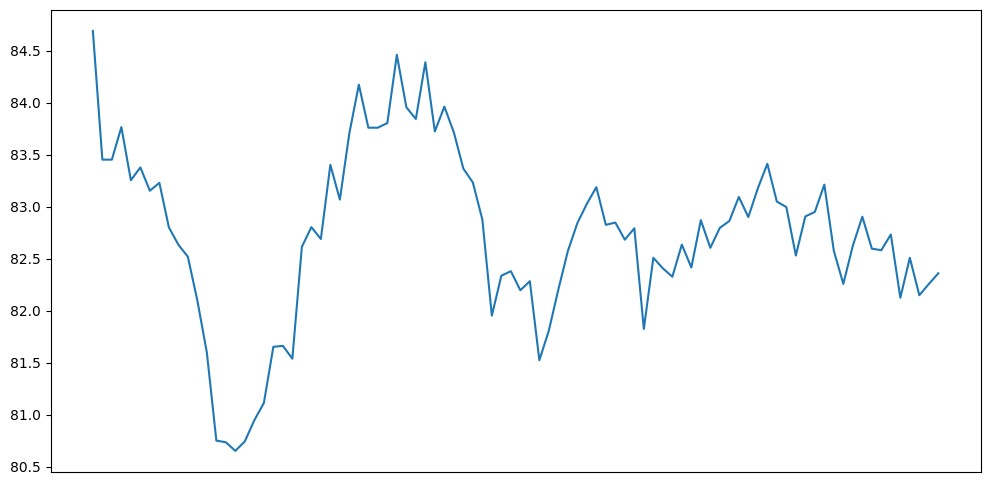

In [143]:
# Train and evaluate the model on USD data
print("Training on USD data")
model_usd = ResCNN()
train_model(model_usd, train_loader_usd, val_loader_usd)
predictions_usd = predict_future(model_usd, X_val_usd, usd_scaler)
plot_results(usd_data, predictions_usd, 'Actual vs. Predicted USD Index')

Training on Bitcoin data


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([30, 1])) that is different to the input size (torch.Size([30, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retur

Epoch 1, Train Loss: 0.05016957223415375, Val Loss: 0.06353607416152954
Epoch 2, Train Loss: 0.04082431271672249, Val Loss: 0.05282845914363861
Epoch 3, Train Loss: 0.11225118488073349, Val Loss: 0.060657260119915006
Epoch 4, Train Loss: 0.055585600435733795, Val Loss: 0.06719929039478302
Epoch 5, Train Loss: 0.058339547365903854, Val Loss: 0.057995717823505405
Epoch 6, Train Loss: 0.03937168046832085, Val Loss: 0.06965252637863159
Epoch 7, Train Loss: 0.14968626201152802, Val Loss: 0.05128804191946983
Epoch 8, Train Loss: 0.08056581765413284, Val Loss: 0.0569316565990448
Epoch 9, Train Loss: 0.04739861562848091, Val Loss: 0.0497036674618721
Epoch 10, Train Loss: 0.06872650235891342, Val Loss: 0.057367277294397355


<ipython-input-142-7b1016442d9e>:12: UserWarning: Discarding nonzero nanoseconds in conversion.
  future_dates = [last_date + pd.DateOffset(days=n) for n in range(1, 91)]


ValueError: x and y must have same first dimension, but have shapes (180,) and (71820, 90)

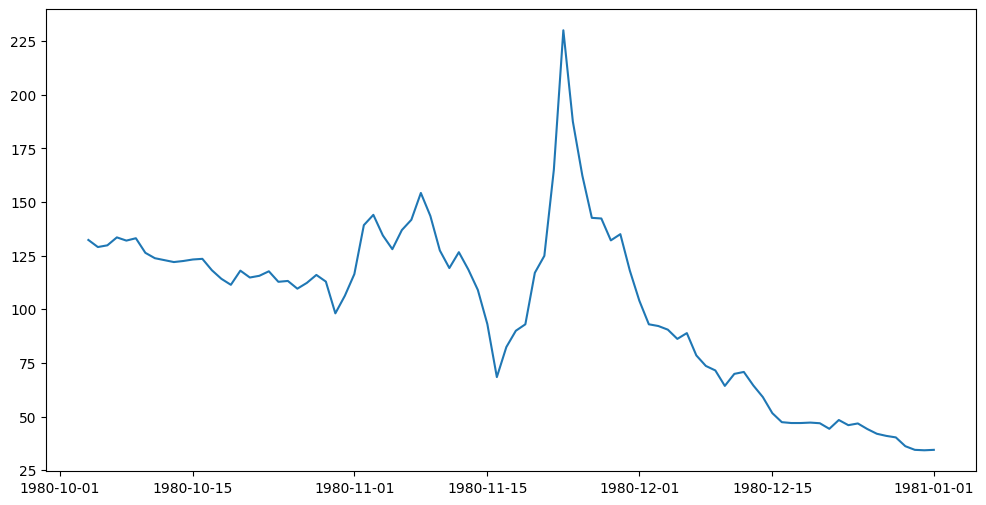

In [144]:
# Train and evaluate the model on Bitcoin data
print("Training on Bitcoin data")
model_bitcoin = ResCNN()
train_model(model_bitcoin, train_loader_bitcoin, val_loader_bitcoin)
predictions_bitcoin = predict_future(model_bitcoin, X_val_bitcoin, bitcoin_scaler)
plot_results(bitcoin_data, predictions_bitcoin, 'Actual vs. Predicted Bitcoin Index')

Training on Nasdaq data


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([29, 1])) that is different to the input size (torch.Size([29, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4, 1, 30])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  retur

Epoch 1, Train Loss: 0.058938298374414444, Val Loss: 0.10233434331085947
Epoch 2, Train Loss: 0.06767506152391434, Val Loss: 0.12026548385620117
Epoch 3, Train Loss: 0.06153841316699982, Val Loss: 0.12924203731947476
Epoch 4, Train Loss: 0.06372908502817154, Val Loss: 0.11855560334192382
Epoch 5, Train Loss: 0.05226144194602966, Val Loss: 0.14308937225076887
Epoch 6, Train Loss: 0.04564332962036133, Val Loss: 0.11847367303238975
Epoch 7, Train Loss: 0.05845452472567558, Val Loss: 0.13039663972126114
Epoch 8, Train Loss: 0.06307300925254822, Val Loss: 0.1275292986796962
Epoch 9, Train Loss: 0.07058922201395035, Val Loss: 0.15074398616949716
Epoch 10, Train Loss: 0.05122632905840874, Val Loss: 0.1398194150792228


<ipython-input-142-7b1016442d9e>:12: UserWarning: Discarding nonzero nanoseconds in conversion.
  future_dates = [last_date + pd.DateOffset(days=n) for n in range(1, 91)]


ValueError: x and y must have same first dimension, but have shapes (180,) and (49320, 90)

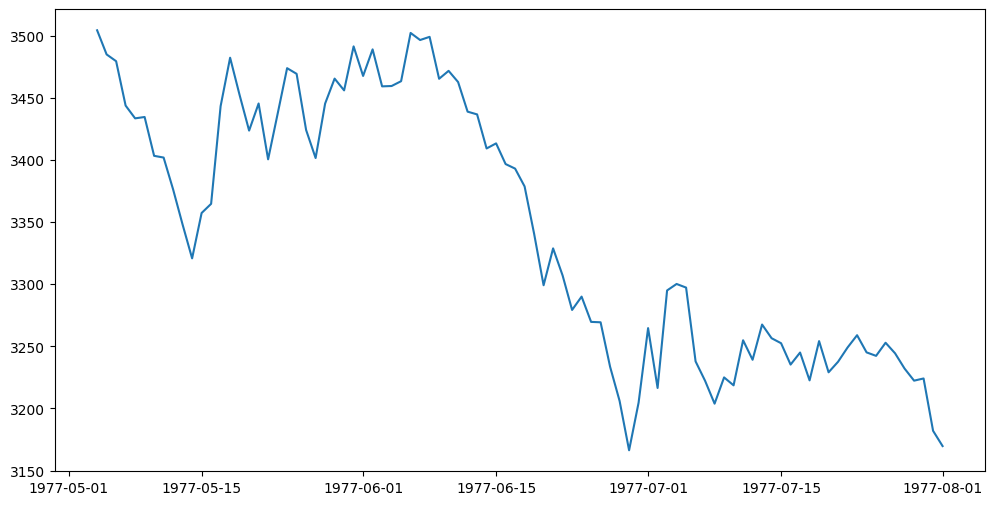

In [145]:
# Train and evaluate the model on Nasdaq data
print("Training on Nasdaq data")
model_nasdaq = ResCNN()
train_model(model_nasdaq, train_loader_nasdaq, val_loader_nasdaq)
predictions_nasdaq = predict_future(model_nasdaq, X_val_nasdaq, nasdaq_scaler)
plot_results(nasdaq_data, predictions_nasdaq, 'Actual vs. Predicted Nasdaq Index')